In [78]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince
%matplotlib inline

# setting up plot style 
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [61]:
#import dataset

df = pd.read_csv('../datasets/data_to_clustering.csv')
#df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP
3,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP
4,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP


In [62]:
#df = df[['review_score','price', 'freight_value','boleto', 'credit_card', 'debit_card']]


In [63]:
#retirando as colunas product_name_lenght e product_description_lenght

#df.drop(columns = ['product_name_lenght', 'product_description_lenght',
#                   'order_purchase_timestamp',
#                   'order_approved_at',
#                   'order_delivered_carrier_date',
#                   'order_delivered_customer_date',
#                   'order_estimated_delivery_date',
#                   'voucher',
#                   'customer_city',
#                   'customer_state'],
#        inplace = True)
df.columns

Index(['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_city', 'customer_state', 'review_score', 'price', 'freight_value', 'product_category_name', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'seller_state'], dtype='object')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_purchase_timestamp       105291 non-null  object 
 1   order_approved_at              105291 non-null  object 
 2   order_delivered_carrier_date   105291 non-null  object 
 3   order_delivered_customer_date  105291 non-null  object 
 4   order_estimated_delivery_date  105291 non-null  object 
 5   customer_city                  105291 non-null  object 
 6   customer_state                 105291 non-null  object 
 7   review_score                   105291 non-null  int64  
 8   price                          105291 non-null  float64
 9   freight_value                  105291 non-null  float64
 10  product_category_name          105291 non-null  object 
 11  payment_sequential             105291 non-null  float64
 12  payment_type                  

# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [65]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [66]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']

#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')

df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP,0.007431,2.373924,8.436574,15.544063,7.107488
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP,0.007431,2.373924,8.436574,15.544063,7.107488
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP,0.007431,2.373924,8.436574,15.544063,7.107488
3,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP,1.279745,1.742627,13.782037,19.137766,5.355729
4,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP,0.011505,0.216100,9.394213,26.639711,17.245498


In [67]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP,0.007431,2.373924,8.436574,15.544063,7.107488
1,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP,0.007431,2.373924,8.436574,15.544063,7.107488
2,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP,0.007431,2.373924,8.436574,15.544063,7.107488
3,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP,1.279745,1.742627,13.782037,19.137766,5.355729
4,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP,0.011505,0.216100,9.394213,26.639711,17.245498


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_city          105291 non-null  object 
 1   customer_state         105291 non-null  object 
 2   review_score           105291 non-null  int64  
 3   price                  105291 non-null  float64
 4   freight_value          105291 non-null  float64
 5   product_category_name  105291 non-null  object 
 6   payment_sequential     105291 non-null  float64
 7   payment_type           105291 non-null  object 
 8   payment_installments   105291 non-null  float64
 9   payment_value          105291 non-null  float64
 10  seller_state           105291 non-null  object 
 11  diff_approved          105291 non-null  float64
 12  diff_carrier           105291 non-null  float64
 13  diff_customer          105291 non-null  float64
 14  diff_estimate          105291 non-nu

## Drop columns

In [69]:
#drop the city column
df.drop(columns = ['customer_city', 'seller_state', 'customer_state', 
                   'product_category_name', 'payment_type', 'payment_sequential'], 
        axis = 1, inplace = True)
df.head()

,review_score,price,freight_value,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,4,29.99,8.72,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488
1,4,29.99,8.72,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488
2,4,29.99,8.72,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488
3,4,118.70,22.76,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729
4,5,159.90,19.22,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   review_score          105291 non-null  int64  
 1   price                 105291 non-null  float64
 2   freight_value         105291 non-null  float64
 3   payment_installments  105291 non-null  float64
 4   payment_value         105291 non-null  float64
 5   diff_approved         105291 non-null  float64
 6   diff_carrier          105291 non-null  float64
 7   diff_customer         105291 non-null  float64
 8   diff_estimate         105291 non-null  float64
 9   diff_est_del          105291 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 8.0 MB


# Model

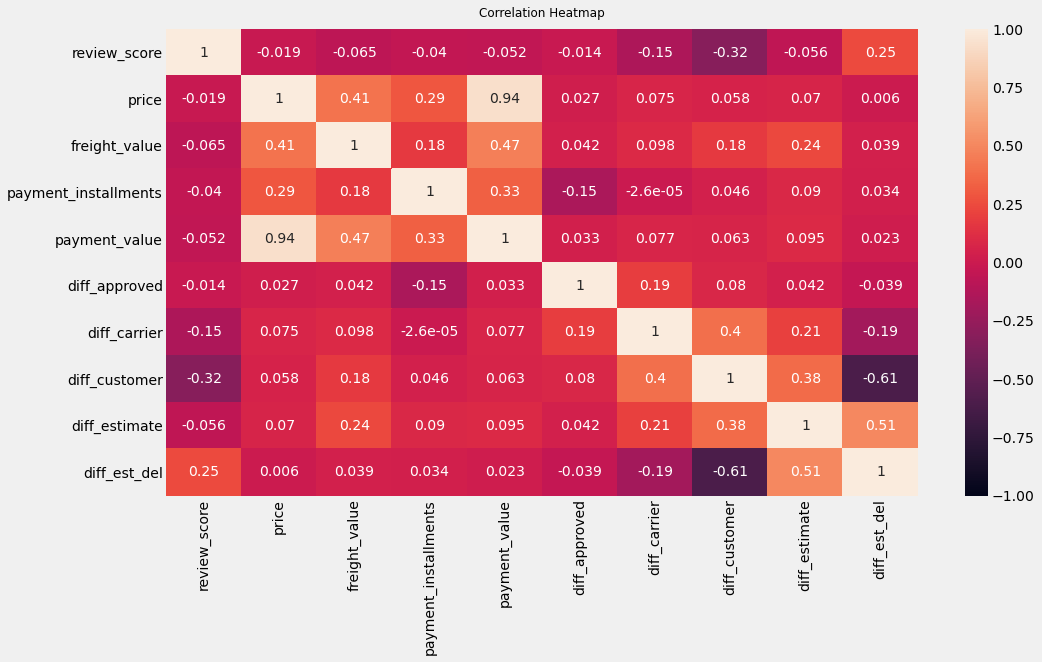

In [71]:
plt.figure(figsize = (15,8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [72]:
scaler = StandardScaler()

Xs = scaler.fit_transform(df)
#X = df.loc[:,:]

### Elbow Curve

In [73]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(Xs)
    sse.append(kmeans.inertia_)


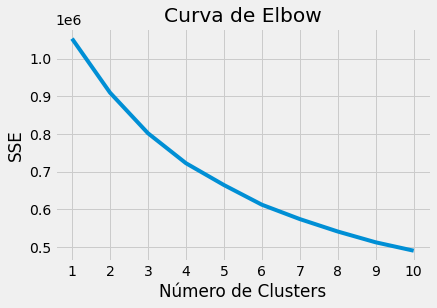

In [74]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Número de Clusters")
plt.title('Curva de Elbow')
plt.ylabel("SSE")
plt.show()

In [75]:
kmeans = KMeans(n_clusters=6,
                init='random',
                n_init = 10,
                max_iter = 300,
                random_state = 42)
kmeans.fit(Xs)
y_kmeans = kmeans.predict(Xs)


In [76]:
df_cluster = df.copy()
df_cluster['cluster'] = y_kmeans
df_cluster.head()

,review_score,price,freight_value,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster
0,4,29.99,8.72,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,3
1,4,29.99,8.72,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,3
2,4,29.99,8.72,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,3
3,4,118.70,22.76,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,3
4,5,159.90,19.22,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,4


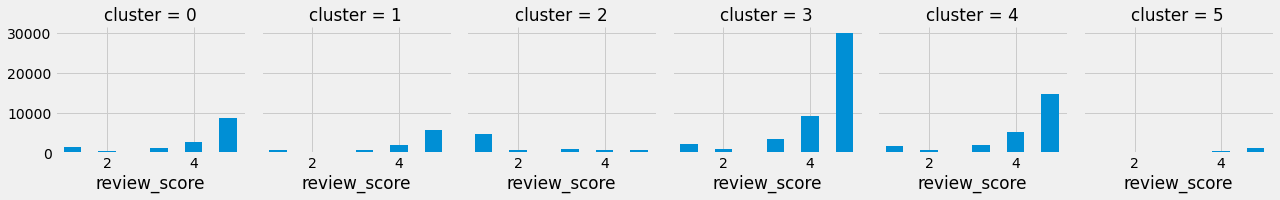

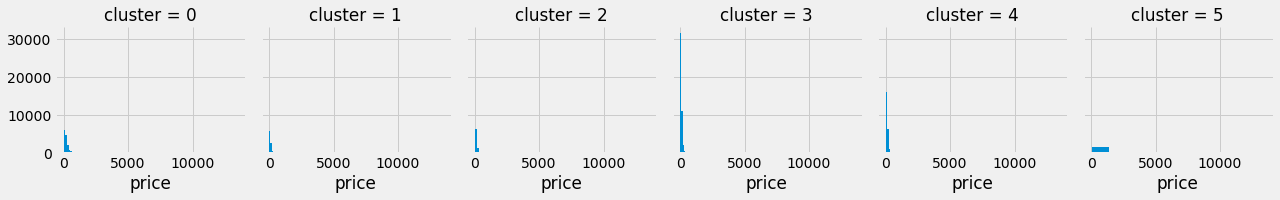

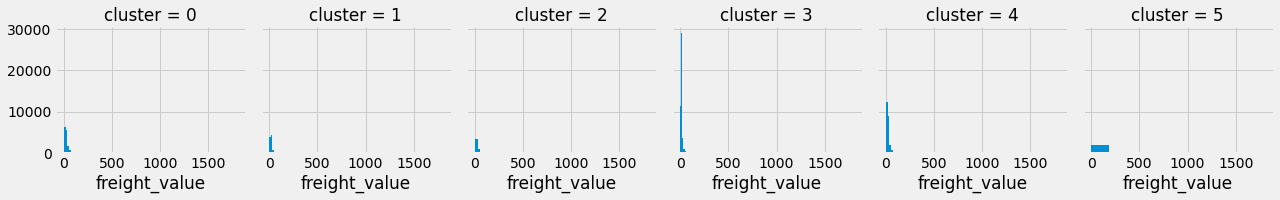

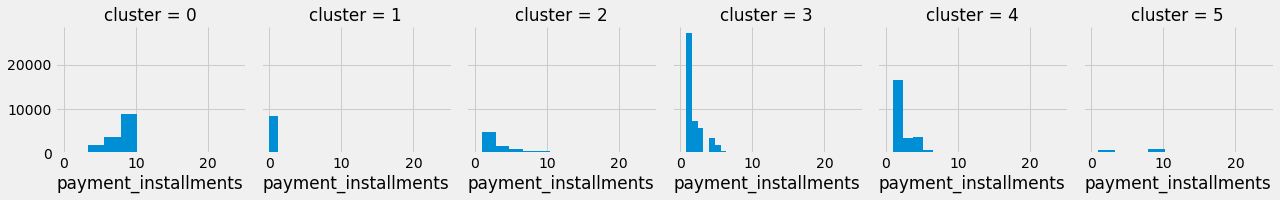

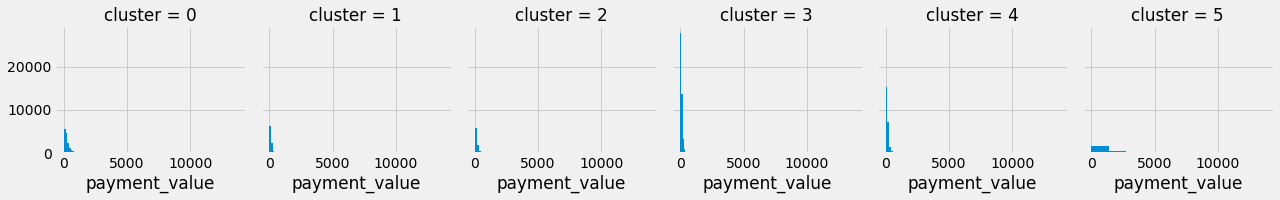

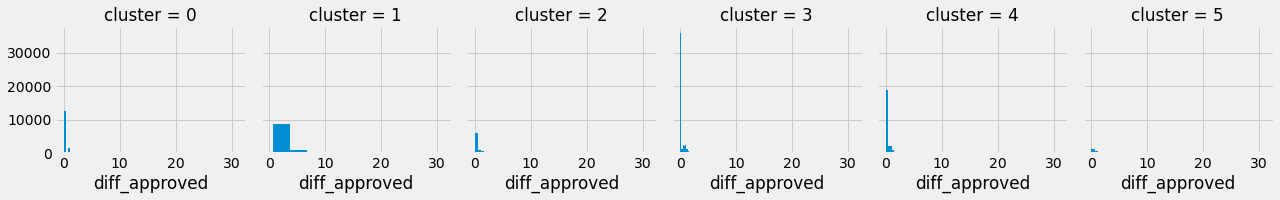

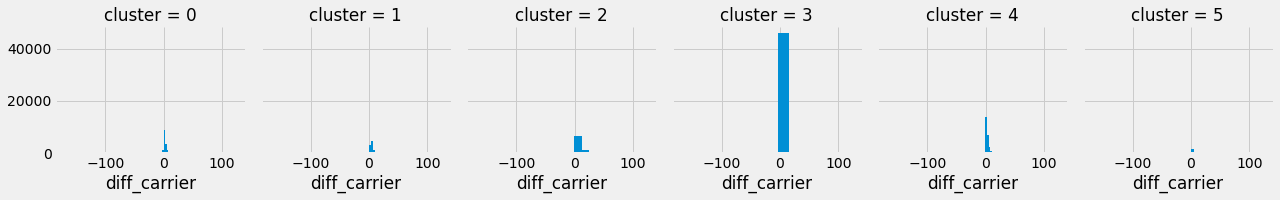

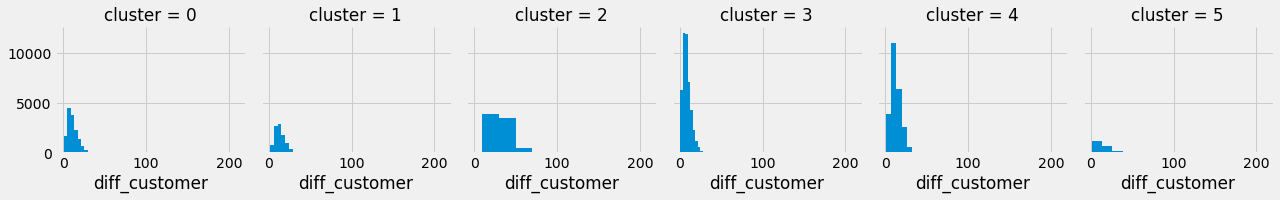

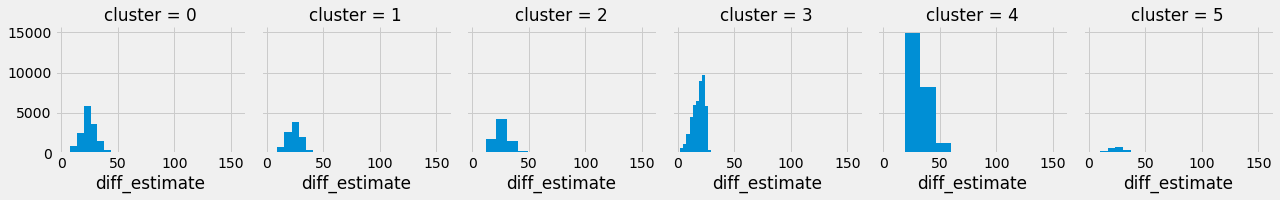

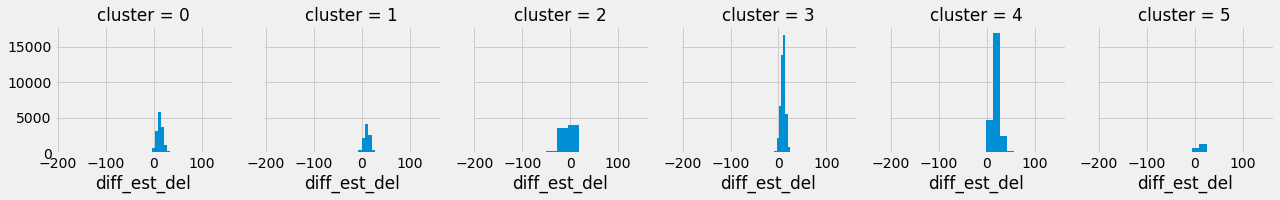

In [77]:
for c in df:
    grid = sns.FacetGrid(df_cluster, col='cluster')
    grid.map(plt.hist, c)

------------------------------------

## Applying PCA

In [79]:
pca = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
pca = pca.fit(df)

In [81]:
pca.transform(df).head()

,0,1
0,-1.431241,-0.257248
1,-1.471679,-0.272655
2,-1.430062,-0.256799
3,-0.325109,-0.556664
4,-0.241172,1.170222


No handles with labels found to put in legend.


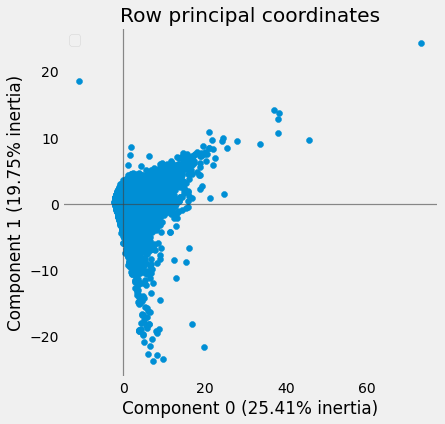

In [83]:
ax = pca.plot_row_coordinates(
    df,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=None,
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)

In [84]:
# applying PCA in dataset

pca = PCA(n_components=min(Xs.shape[0],Xs.shape[1]))
d=pca.fit_transform(Xs)

In [85]:
scree = pca.explained_variance_ratio_
nbr_pca=0
N=110
for i in range(N):
    a = scree.cumsum()[i]
    if a >= 0.80:
        print("{} principal components explain at least 80% of the total variance".format(i))
        print("Exact value of variance explained: {}%".format(round(a*100,2)))
        nbr_pca=i
        break
pca = PCA(n_components=nbr_pca)
d=pca.fit_transform(Xs)

5 principal components explain at least 80% of the total variance
Exact value of variance explained: 86.72%


In [86]:
data_pca=pd.DataFrame(d)
col=["pca "+ str(n+1) for n in data_pca.columns]
data_pca.columns=col
data_pca.head()

,pca 1,pca 2,pca 3,pca 4,pca 5
0,-1.431241,-0.257248,0.829113,-0.053178,0.173972
1,-1.471679,-0.272655,0.814039,-0.063514,0.170143
2,-1.430062,-0.256799,0.829553,-0.052877,0.174084
3,-0.325109,-0.556664,0.481522,1.045666,0.477919
4,-0.241172,1.170222,-0.134055,-0.330913,-0.148714


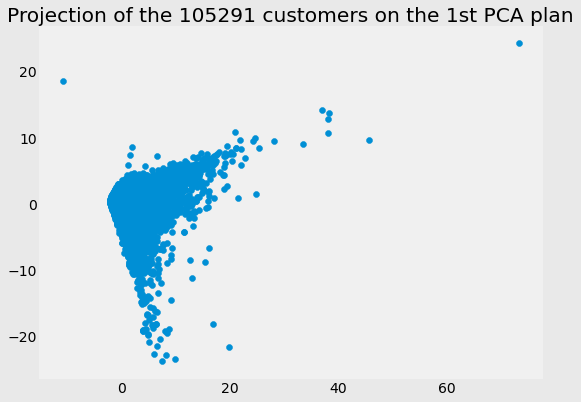

In [87]:
fig=plt.figure(figsize=[8,6])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Projection of the {} customers on the 1st PCA plan".format(data_pca.shape[0]))
plt.scatter(data=data_pca,x="pca 1",y="pca 2")
plt.grid()

In [88]:
pca = PCA(n_components=5)
principalComponents  = pca.fit_transform(Xs)

In [89]:
principalComponents

array([[-1.431241  , -0.25724814,  0.82911335, -0.05317811,  0.17397201],
       [-1.47167889, -0.27265517,  0.8140391 , -0.06351405,  0.17014283],
       [-1.43006198, -0.25679893,  0.82955286, -0.05287675,  0.17408366],
       ...,
       [ 1.87421427, -0.05052614, -0.14946715, -0.78535025, -0.57914957],
       [ 3.26786429,  0.4625986 , -1.19729139, -0.87398118,  1.60449901],
       [-0.93580354,  0.79551583, -0.43651105,  0.49640033,  0.08218211]])

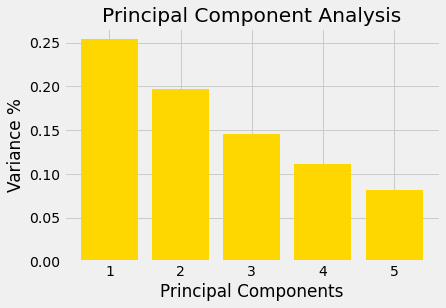

In [90]:
# Plotting the variances for each PC
plt.style.use("fivethirtyeight")
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.title('Principal Component Analysis')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)


In [91]:
PCA_components.head()

,0,1,2,3,4
0,-1.431241,-0.257248,0.829113,-0.053178,0.173972
1,-1.471679,-0.272655,0.814039,-0.063514,0.170143
2,-1.430062,-0.256799,0.829553,-0.052877,0.174084
3,-0.325109,-0.556664,0.481522,1.045666,0.477919
4,-0.241172,1.170222,-0.134055,-0.330913,-0.148714


In [92]:
pca.explained_variance_ratio_.sum()

0.7911329678698512

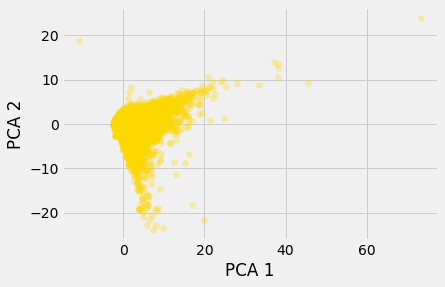

In [42]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


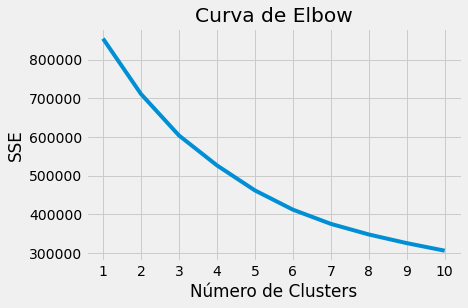

In [50]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_components)
    sse.append(kmeans.inertia_)

#plot:
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Número de Clusters")
plt.ylabel("SSE")
plt.title('Curva de Elbow')
plt.show()
    


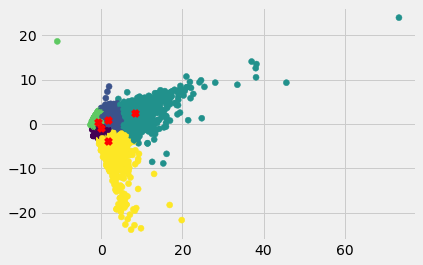

In [51]:
model = KMeans(n_clusters=5)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])

#plot
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

plt.show()


In [52]:
kmeans = KMeans(n_clusters=5,
                init='random',
                n_init = 10,
                max_iter = 300,
                random_state = 42)
kmeans.fit(PCA_components)
y_kmeans = kmeans.predict(PCA_components)



In [54]:
df_with_clusters = df.copy()
df_with_clusters['cluster'] = y_kmeans
df_with_clusters.head()

,review_score,price,freight_value,payment_sequential,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster
0,4,29.99,8.72,1.0,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,3
1,4,29.99,8.72,3.0,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,3
2,4,29.99,8.72,2.0,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,3
3,4,118.70,22.76,1.0,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,3
4,5,159.90,19.22,1.0,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,4


## Clusters EDA

In [55]:
conditions = [
    df_with_clusters['cluster'] == 0,
    df_with_clusters['cluster'] == 1,
    df_with_clusters['cluster'] == 2,
    df_with_clusters['cluster'] == 3,
    df_with_clusters['cluster'] == 4
]

values = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

df_with_clusters['cluster_name'] = np.select(conditions,values)
df_with_clusters.head()

,review_score,price,freight_value,payment_sequential,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster,cluster_name
0,4,29.99,8.72,1.0,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,3,Cluster 4
1,4,29.99,8.72,3.0,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,3,Cluster 4
2,4,29.99,8.72,2.0,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,3,Cluster 4
3,4,118.70,22.76,1.0,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,3,Cluster 4
4,5,159.90,19.22,1.0,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,4,Cluster 5


In [56]:
df_with_clusters['cluster_name'].value_counts()

Cluster 4    55820
Cluster 5    34798
Cluster 1    10919
Cluster 3     3134
Cluster 2      620
Name: cluster_name, dtype: int64

In [57]:
cluster_1 = df_with_clusters[df_with_clusters['cluster'] == 0]
cluster_2 = df_with_clusters[df_with_clusters['cluster'] == 1]
cluster_3 = df_with_clusters[df_with_clusters['cluster'] == 2]
cluster_4 = df_with_clusters[df_with_clusters['cluster'] == 3]
cluster_5 = df_with_clusters[df_with_clusters['cluster'] == 4]

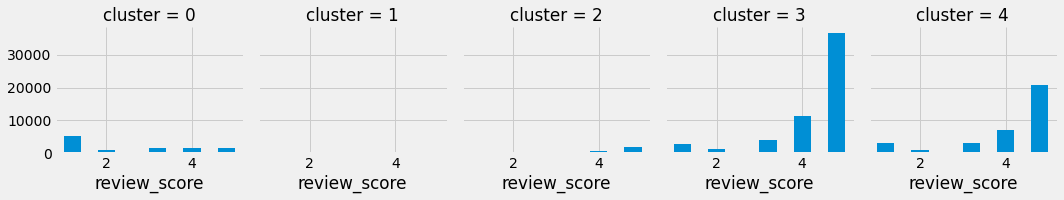

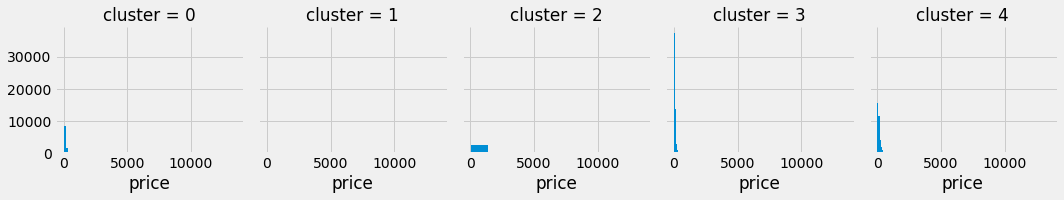

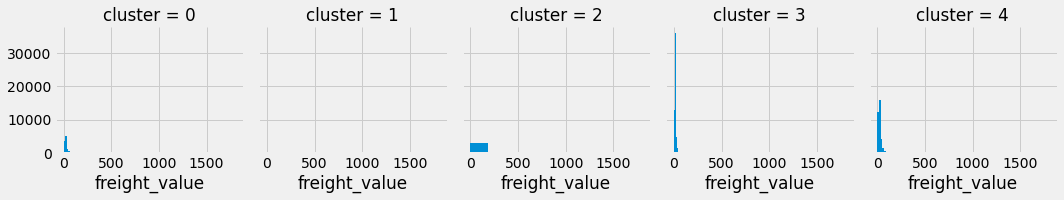

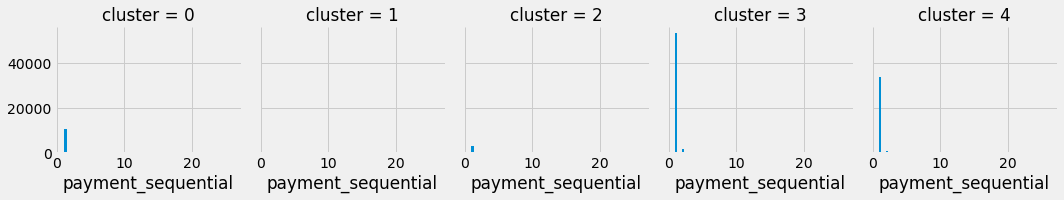

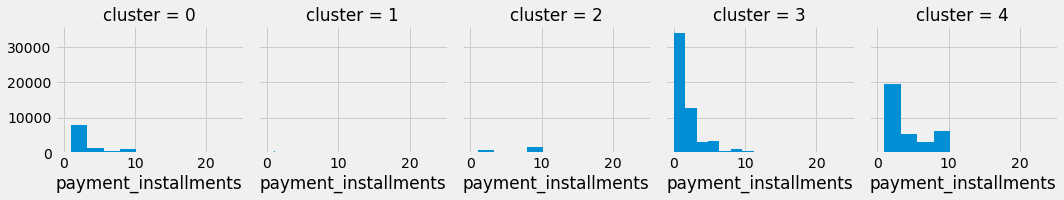

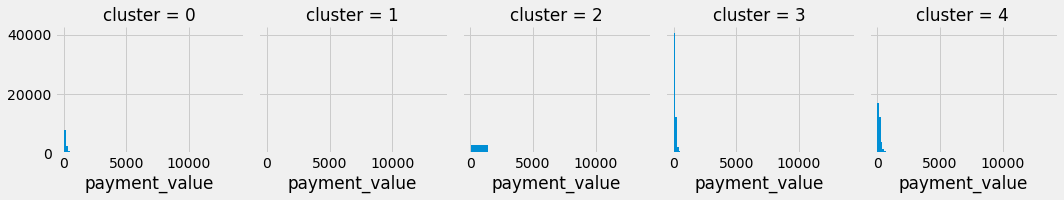

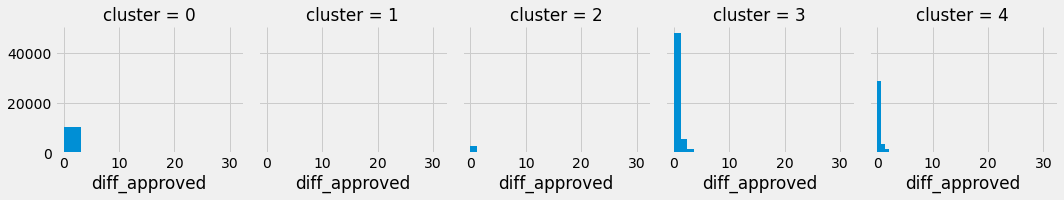

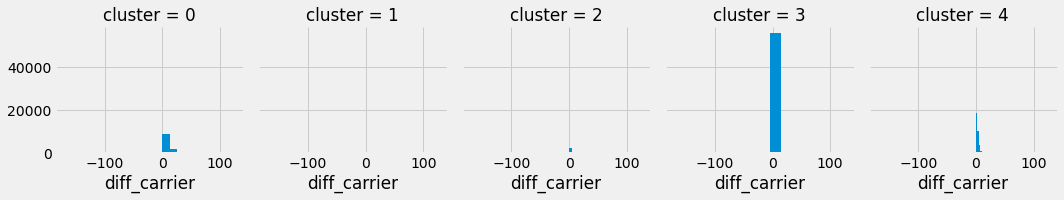

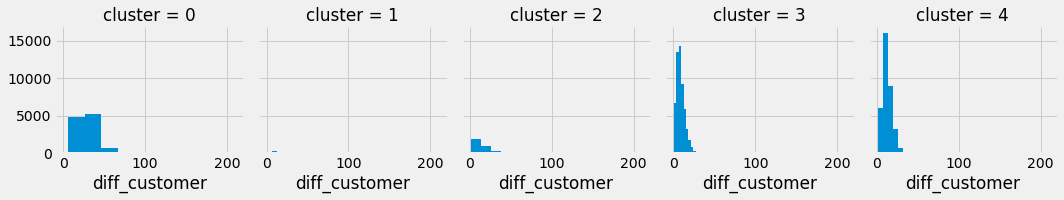

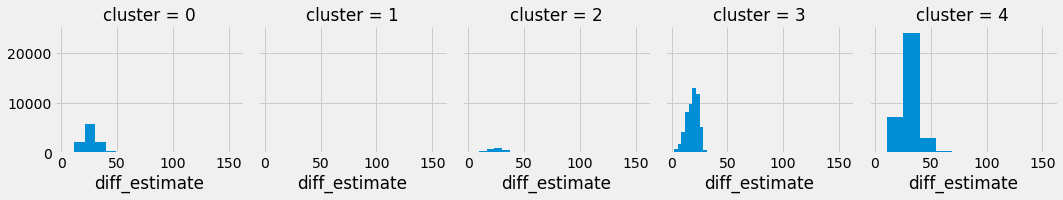

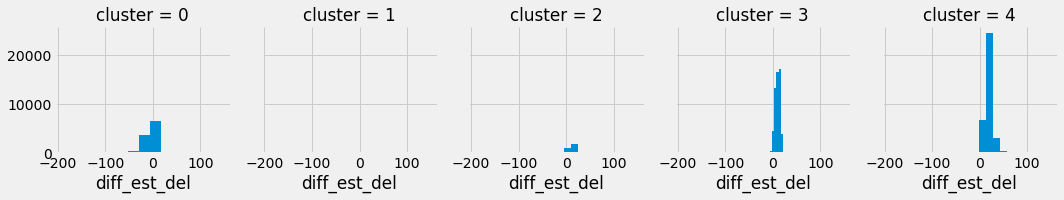

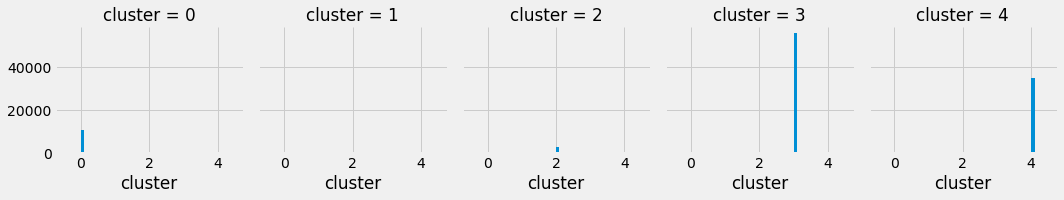

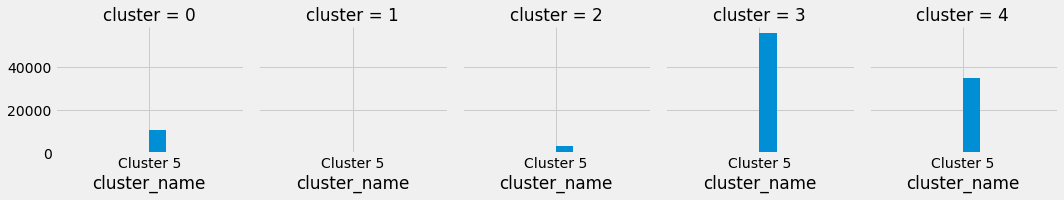

In [59]:
for c in df_with_clusters:
    grid = sns.FacetGrid(df_with_clusters, col='cluster')
    grid.map(plt.hist, c)

### Reviews

In [ ]:
rs_prop_1 = cluster_1['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_1['Cluster'] = 'Cluster 1'

rs_prop_2 = cluster_2['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_2['Cluster'] = 'Cluster 2'

rs_prop_3 = cluster_3['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_3['Cluster'] = 'Cluster 3'

rs_prop_4 = cluster_4['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_4['Cluster'] = 'Cluster 4'

rs_prop_5 = cluster_5['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_5['Cluster'] = 'Cluster 5'

rs_prop_6 = cluster_6['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_6['Cluster'] = 'Cluster 6'

rs_prop = pd.concat([rs_prop_1,rs_prop_2, rs_prop_3, rs_prop_4, rs_prop_5, rs_prop_6])
rs_prop

In [ ]:
sns.barplot(x='review_score',
            y = 'percent',
            hue = 'Cluster',
            data = rs_prop,
            palette = 'mako')
plt.show()

### Price

In [ ]:
ax = sns.boxplot(y = 'price',
                 x = 'cluster_name',
                 data = df_with_clusters,
                 palette = 'viridis',
                 order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

In [ ]:
ax = sns.boxplot(y = 'freight_value',
            x = 'cluster_name',
            data = df_with_clusters,
            palette = 'mako',
            order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

### Payment type

In [ ]:
pmt_type = df_with_clusters[['boleto','credit_card', 'debit_card', 'cluster_name']]
pmt_type.head()

In [ ]:
pmt_type.groupby('cluster_name').sum()

Não há diferença entre grupos em relação a tipo de pagamento.

### Região

In [ ]:
df_regiao = df_with_clusters[['customer_region_centro_oeste',
                              'customer_region_nordeste',
                              'customer_region_norte',
                              'customer_region_sudeste',
                              'customer_region_sul',
                              'cluster_name']]

In [ ]:
df_regiao.head()

In [ ]:
regiao_grouped = df_regiao.groupby('cluster_name').sum()
regiao_grouped

In [ ]:
regiao_grouped.idxmax(axis=1)

#### Capital

In [ ]:
capital_prop_1 = cluster_1['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_1['Cluster'] = 'Cluster 1'

capital_prop_2 = cluster_2['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_2['Cluster'] = 'Cluster 2'

capital_prop_3 = cluster_3['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_3['Cluster'] = 'Cluster 3'

capital_prop_4 = cluster_4['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_4['Cluster'] = 'Cluster 4'

capital_prop = pd.concat([capital_prop_1,capital_prop_2, capital_prop_3, capital_prop_4])
capital_prop

In [ ]:
#Plot capital

sns.barplot(x='customer_capital',
            y = 'percent',
            hue = 'Cluster',
            data = capital_prop,
            palette = 'viridis')
plt.show()

### Categoria de Produtos

In [ ]:
categ_prod = df_with_clusters[['product_category_name_bebes',
'product_category_name_beleza_saude',
'product_category_name_brinquedos',
'product_category_name_cama_mesa_banho',
'product_category_name_consoles_games',
'product_category_name_construcao_ferramentas_construcao',
'product_category_name_cool_stuff',
'product_category_name_eletrodomesticos',
'product_category_name_eletronicos',
'product_category_name_eletroportateis',
'product_category_name_esporte_lazer',
'product_category_name_fashion_bolsas_e_acessorios',
'product_category_name_ferramentas_jardim',
'product_category_name_informatica_acessorios',
'product_category_name_instrumentos_musicais',
'product_category_name_livros_interesse_geral',
'product_category_name_malas_acessorios',
'product_category_name_moveis_decoracao',
'product_category_name_moveis_escritorio',
'product_category_name_no info',
'product_category_name_papelaria',
'product_category_name_perfumaria',
'product_category_name_pet_shop',
'product_category_name_relogios_presentes',
'product_category_name_telefonia',
'product_category_name_utilidades_domesticas',
'cluster_name']]

In [ ]:
categ_prod.head()

In [ ]:
categ_grouped = categ_prod.groupby('cluster_name').sum()
categ_grouped

In [ ]:
categ_grouped.idxmax(axis=1)

In [ ]:
df_with_clusters.head()

### Tempo de entrega

In [ ]:
time_delivered = df_with_clusters[['diff_approved', 
                                   'diff_carrier',
                                   'diff_customer',
                                   'diff_estimate',
                                   'diff_est_del',
                                   'cluster_name']]

time_delivered.head()

In [ ]:
time_del_grouped = time_delivered.groupby('cluster_name').mean().reset_index()
time_del_grouped

In [ ]:
tidy_time_del_grouped = time_del_grouped.melt(id_vars='cluster_name').rename(columns=str.title)
tidy_time_del_grouped

In [ ]:
ax = fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='Cluster_Name', 
                 y='Value', 
                 hue='Variable', 
                 data=tidy_time_del_grouped, 
                 ax=ax,
                 palette = 'mako',
                 order = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'CLuster 4', 'Cluster 5', 'Cluster 6'])
sns.despine(fig)